load external packages

In [1]:
from pathlib import Path
from typing import List
import functools

import numpy as np
import pandas as pd
from skimage import io
import cv2
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

from settings import SizeLabel

%matplotlib inline

extract image path for inria image dataset

In [2]:
image_paths = list(Path('../input/AerialImageDataset/train/images').glob('./*'))

show aerial image (to be feed as network input)

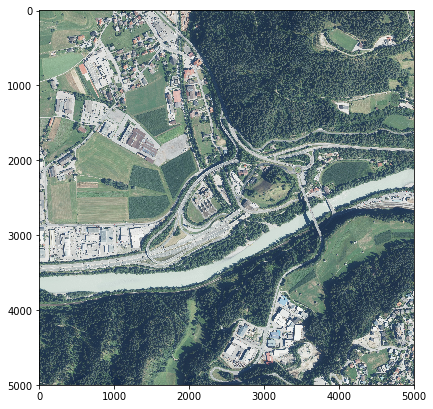

In [3]:
def show_img(img_path: Path):
    plt.figure(figsize=(6, 6))
    image = io.imread(img_path.as_posix())
    io.imshow(image)

image_path = image_paths[2]
show_img(image_path)

show gt image (to be feed as network output)

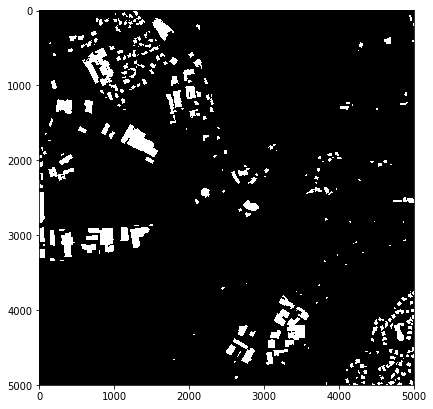

In [4]:
gt_path = image_path.parent.parent.joinpath('gt', image_path.name)
show_img(gt_path)

calculate building areas on image

In [5]:
def areas_on_image(image: np.ndarray) -> List[float]:
    contours, hierarchy = cv2.findContours(
        image,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
    areas = {}

    for idx, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        parent_idx = hierarchy[0][idx][3]
        if parent_idx >= 0:  # suppose there doesnt exist more than two layer hierarchy
            if parent_idx in areas:
                areas[parent_idx] -= area
            else:
                areas[parent_idx] = -area
        else:
            if idx in areas:
                areas[idx] += area
            else:
                areas[idx] = area

    return list(areas.values())

In [6]:
def gt_by_image_path(image_path: Path) -> np.ndarray:
    gt_path = image_path.parent.parent.joinpath('gt', image_path.name)
    gt_image = io.imread(gt_path.as_posix())
    return gt_image

In [7]:
def compose(*funcs):
    return functools.reduce(lambda f, g: lambda *args, **kwargs: g(f(*args, **kwargs)), funcs)

In [8]:
areas_list = Parallel(n_jobs=-1)(delayed(compose(gt_by_image_path, areas_on_image))(path) for path in image_paths)
area_df = pd.DataFrame({'area': [area for areas in areas_list for area in areas]})

show histgram of areas

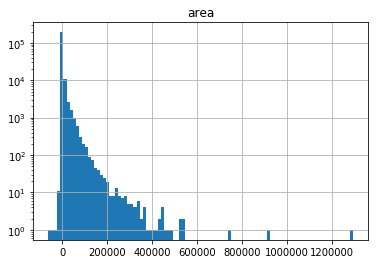

In [9]:
area_df.hist(bins=100)
plt.yscale('log')

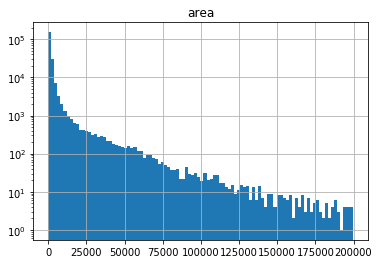

In [10]:
area_df.query("0 < area < 200000").hist(bins=100)
plt.yscale('log')

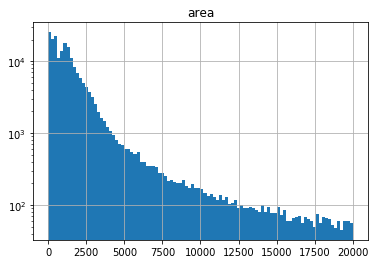

In [11]:
area_df.query("0 < area < 20000").hist(bins=100)
plt.yscale('log')

fix lower bound to 400 and upper bound to 80000 from histgrams above

and calculate threshold by Kmeans for square root areas

In [12]:
x = np.array(area_df.area).reshape(-1, 1)
x = x[(x > 400) & (x < 80000)].reshape(-1, 1)
sq = np.sqrt(x)
k = 3
y = KMeans(n_clusters=k, n_jobs=-1).fit_predict(sq)
cluster_results = pd.DataFrame({'x': x.reshape(-1), 'y': y}).sort_values('x').reset_index(drop=True)
thresholds = pd.DataFrame({'area': cluster_results.groupby('y')['x'].max().sort_values()}).reset_index(drop=True)

calculated threshold below

In [13]:
thresholds

,area
0,3446.5
1,18834.5
2,79983.5


this function transform gt image to coloring label by building size

In [14]:
def transform_to_sizelabel(bin_image: np.ndarray) -> np.ndarray:
    contours, hierarchy = cv2.findContours(
        bin_image,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )

    height, width = bin_image.shape[0], bin_image.shape[1]
    image = np.zeros((height, width, 3), dtype=np.uint8)

    for idx, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        parent_idx = hierarchy[0][idx][3]
        if parent_idx >= 0:  
            image = cv2.drawContours(image, [contour], -1, SizeLabel.blank.value.rgb, -1)
        elif area <= 3400:
            image = cv2.drawContours(image, [contour], -1, SizeLabel.small.value.rgb, -1)
        elif area >= 3400 and area < 18800:
            image = cv2.drawContours(image, [contour], -1, SizeLabel.medium.value.rgb, -1)
        elif area >= 18800:
            image = cv2.drawContours(image, [contour], -1, SizeLabel.large.value.rgb, -1)

    return image

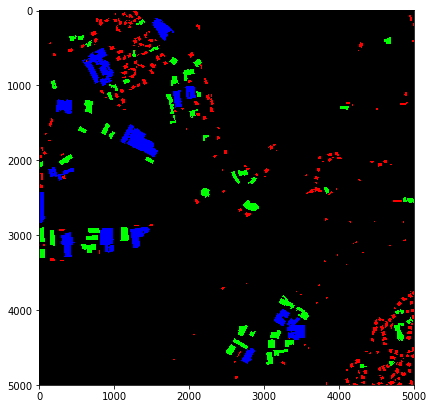

In [15]:
gt_image = io.imread(gt_path.as_posix())
sizelabel_image = transform_to_sizelabel(gt_image)
plt.figure(figsize=(6, 6))
io.imshow(sizelabel_image)